
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsRestClassifier

In [93]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [94]:
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [95]:
ha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      273 non-null    int64
 1   sex      273 non-null    int64
 2   cp       273 non-null    int64
 3   trtbps   273 non-null    int64
 4   chol     273 non-null    int64
 5   restecg  273 non-null    int64
 6   thalach  273 non-null    int64
 7   output   273 non-null    int64
dtypes: int64(8)
memory usage: 17.2 KB


In [96]:
ha.isna().sum()

age        0
sex        0
cp         0
trtbps     0
chol       0
restecg    0
thalach    0
output     0
dtype: int64

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [97]:
ct = ColumnTransformer(
    [('Scaling',StandardScaler(),['age','trtbps','chol','thalach'])],
    remainder='passthrough'
    )

In [98]:

pipe_knn = Pipeline([
    ('ct',ct),
    ('knn',KNeighborsClassifier())
])
pipe_tree = Pipeline([
    ('ct',ct),
    ('tree',DecisionTreeClassifier())
])
pipe_lda = Pipeline([
    ('ct',ct),
    ('lda',LinearDiscriminantAnalysis())
])

In [99]:
X = ha.drop('output',axis=1)
y = ha['output']

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

In [101]:
pipe_knn.fit(X_train,y_train)
pipe_tree.fit(X_train,y_train)
pipe_lda.fit(X_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Scaling', StandardScaler(),
                                                  ['age', 'trtbps', 'chol',
                                                   'thalach'])])),
                ('lda', LinearDiscriminantAnalysis())])

In [102]:
models = {'KNN': pipe_knn,'LDA': pipe_lda, 'Decision Tree': pipe_tree }
for name, model in models.items():
    print(f"Model: {name}")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print()

Model: KNN
              precision    recall  f1-score   support

           0       0.55      0.65      0.60        26
           1       0.62      0.52      0.57        29

    accuracy                           0.58        55
   macro avg       0.59      0.59      0.58        55
weighted avg       0.59      0.58      0.58        55

[[17  9]
 [14 15]]

Model: LDA
              precision    recall  f1-score   support

           0       0.78      0.69      0.73        26
           1       0.75      0.83      0.79        29

    accuracy                           0.76        55
   macro avg       0.77      0.76      0.76        55
weighted avg       0.77      0.76      0.76        55

[[18  8]
 [ 5 24]]

Model: Decision Tree
              precision    recall  f1-score   support

           0       0.63      0.73      0.68        26
           1       0.72      0.62      0.67        29

    accuracy                           0.67        55
   macro avg       0.68      0.68      0.67  

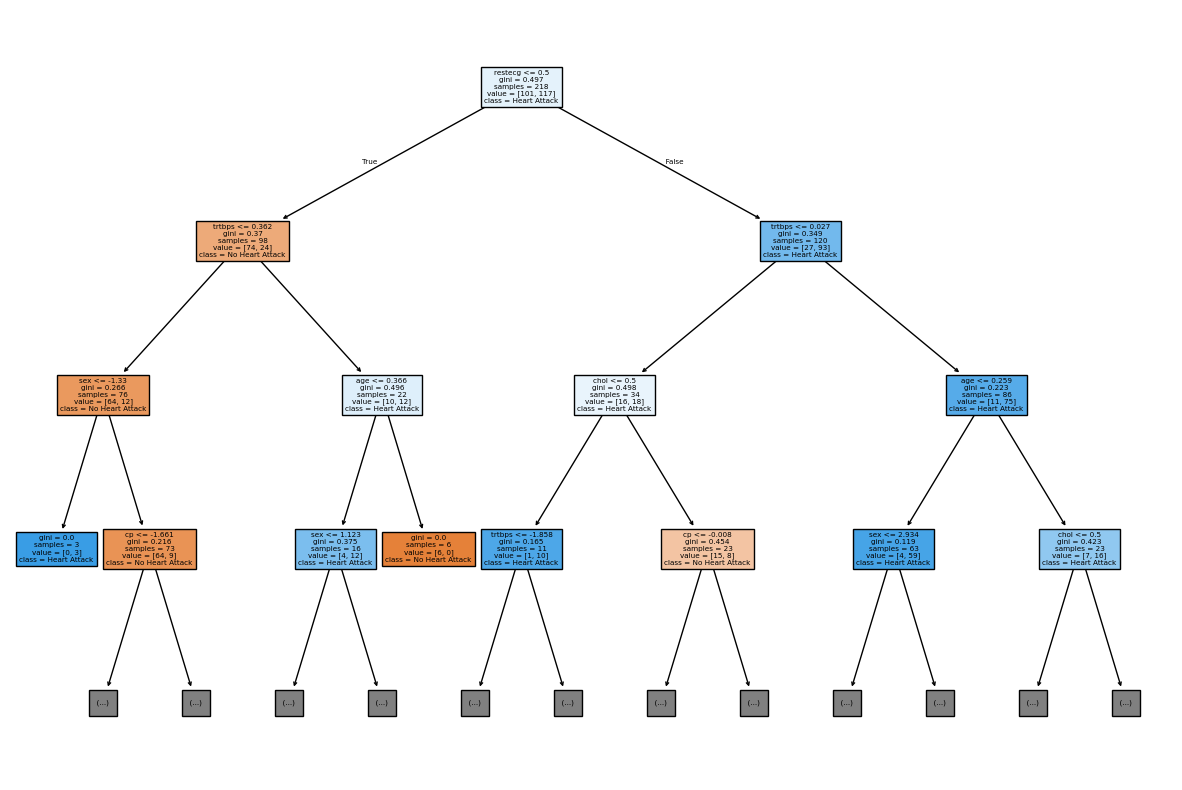

In [103]:
plt.figure(figsize=(15, 10))
plot_tree(pipe_tree.named_steps['tree'], 
          feature_names=X.columns, 
          class_names=['No Heart Attack', 'Heart Attack'], 
          filled=True,
          max_depth=3)
plt.show()

First split is resterg, which implies is has the maximum influence on the prediction. then is splits in two nodes in which one is trtbps is less than .364 and other is less than .037 . 

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

ChatGPT was used to debug the code.

In [104]:
# Create columns for each `cp` category
f1_scores = {}
for cp_val in range(4):
    ha[f'cp_is_{cp_val}'] = np.where(ha['cp'] == cp_val, 1, 0)
    X = ha.drop([f'cp_is_{cp_val}', 'cp'], axis=1)  # Exclude target and cp
    y = ha[f'cp_is_{cp_val}']
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    # Fit Logistic Regression
    log_reg = LogisticRegression(max_iter=1000, random_state=42)
    log_reg.fit(X_train, y_train)
    
    # Predict and calculate F1 score
    y_pred = log_reg.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores[f'cp_is_{cp_val}'] = f1

# Display F1 scores
for cp_category, score in f1_scores.items():
    print(f"{cp_category}: F1 Score = {score:.4f}")

# Find the best category
best_category = max(f1_scores, key=f1_scores.get)
print(f"\nBest distinguishing category: {best_category}")


cp_is_0: F1 Score = 0.7500
cp_is_1: F1 Score = 0.2857
cp_is_2: F1 Score = 0.9143
cp_is_3: F1 Score = 0.6667

Best distinguishing category: cp_is_2


## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [106]:
def ovo(df, target):
    y = df[target]
    X = df.drop(['cp',"cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0"], axis=1)
    
    # Preprocessing pipeline (standardize the numerical features)
    preprocessing = ColumnTransformer(
        transformers=[
            ("standardize", StandardScaler(), ['trtbps', 'chol', 'thalach'])
        ],
        remainder="passthrough"
    )
    
    # Logistic Regression with One-vs-Rest
    pipe_logic = Pipeline([
        ("preprocessing", preprocessing),
        ("logistic", OneVsRestClassifier(LogisticRegression(max_iter=500, random_state=123)))
    ])
    
    # Perform 10-fold cross-validation and compute F1-macro score
    f1_scores = cross_val_score(pipe_logic, X, y, cv=10, scoring="f1_macro")
    avg_f1 = f1_scores.mean()
    print(f"Mean F1-macro score for {target}: {avg_f1:.4f}")

# Define the binary targets you want to evaluate
binary_targets = ["cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0"]

# Use the function to evaluate each target
for target in binary_targets:
    ovo(ha, target)


Mean F1-macro score for cp_is_3: 0.4810
Mean F1-macro score for cp_is_2: 0.4142
Mean F1-macro score for cp_is_1: 0.4540
Mean F1-macro score for cp_is_0: 0.6678


cp_is_0 show the best results among all.